<a href="https://colab.research.google.com/github/Agoston03/Deep-Learning-42/blob/main/deep_learning_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***This is a Draft version***
### **Our goal is to achieve the offered grade. The current solution is still under development**.




This is a homework project in "Deep Learning a gyakorlatban Python és Lua alapokon".  
The team members are:

* Gyulai Gergő László
* Horváth Ágoston
* Frink Dávid

You can read more information about our chosen homework at the link below:  
https://www.kaggle.com/competitions/isic-2024-challenge

###*Download and setup*


In this section, we will download the necessary libraries and tools.

Download the Kaggle library

In [1]:
!pip install kaggle==1.5.12
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=fde8eb8716a7ab281f57ad7be7f6b22151e212c7e87113f2981ff1140d6fe54f
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


Configure Kaggle to access the API  
**Warning!** You need to copy your own kaggle.json file into Colab in order to validate yourself

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the data

In [3]:
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [01:31<00:00, 22.6MB/s]
100% 2.00G/2.00G [01:31<00:00, 23.5MB/s]


Unpacking the data  
**Warning!** This might take a few minuttes

In [4]:
!unzip isic-2024-challenge.zip -x "train-image/image/*"

Archive:  isic-2024-challenge.zip
  inflating: sample_submission.csv   
  inflating: test-image.hdf5         
  inflating: test-metadata.csv       
  inflating: train-image.hdf5        
  inflating: train-metadata.csv      


Importing the Required Libraries

In [5]:
import pandas as pd
import numpy as np

from PIL import Image
import io
import h5py
import matplotlib.pyplot as plt
import os
from math import ceil

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [6]:
NUMBER_OF_AUGMENTATIONS = 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

### *Preparing train, test and valid set*

In this section we will create the required datasets for further fitting.

Gather information about the dataset based on the metadata

In [7]:
metadata = pd.read_csv('train-metadata.csv')
metadata.head()

<ipython-input-7-4c180bfb1031>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


Lets check the number of benign and malignant data

In [8]:
benign_samples = metadata[metadata['target'] == 0]
malignant_samples = metadata[metadata['target'] == 1]

print(f'Benign images: {len(benign_samples)}')
print(f'Malignant images: {len(malignant_samples)}')

Benign images: 400666
Malignant images: 393


It shows a sample Ids.

In [9]:
benign_ids = benign_samples['isic_id'].tolist()
malignant_ids = malignant_samples['isic_id'].tolist()

print(f'Benign images ids: {benign_ids[:5]}')
print(f'Malignant images ids: {malignant_ids[:5]}')

Benign images ids: ['ISIC_0015670', 'ISIC_0015845', 'ISIC_0015864', 'ISIC_0015902', 'ISIC_0024200']
Malignant images ids: ['ISIC_0082829', 'ISIC_0096034', 'ISIC_0104229', 'ISIC_0119495', 'ISIC_0157834']


In this section we will create the datasets for the further fitting processes.

In [10]:
end = len(malignant_ids) * (NUMBER_OF_AUGMENTATIONS + 1)
benign_ids_sampled = benign_ids[:end]

test_split = 0.1
valid_split = 0.1

test_benign_ids = benign_ids_sampled[:int(len(benign_ids_sampled) * test_split)]
test_malignant_ids = malignant_ids[:int(len(malignant_ids) * test_split)]

valid_benign_ids = benign_ids_sampled[int(len(benign_ids_sampled) * test_split):int(len(benign_ids_sampled) * (test_split + valid_split))]
valid_malignant_ids = malignant_ids[int(len(malignant_ids) * test_split):int(len(malignant_ids) * (test_split + valid_split))]

train_benign_ids = benign_ids_sampled[int(len(benign_ids_sampled) * (test_split + valid_split)):]
train_malignant_ids = malignant_ids[int(len(malignant_ids) * (test_split + valid_split)):]

print(f'Test benign images: {len(test_benign_ids)}')
print(f'Test malignant images: {len(test_malignant_ids)}')

print(f'Valid benign images: {len(valid_benign_ids)}')
print(f'Valid malignant images: {len(valid_malignant_ids)}')

print(f'Train benign images: {len(train_benign_ids)}')
print(f'Train malignant images: {len(train_malignant_ids)}')

Test benign images: 157
Test malignant images: 39
Valid benign images: 157
Valid malignant images: 39
Train benign images: 1258
Train malignant images: 315


We want to train another model on the metadata. The if both models say true then the leisure is probably malignant. Here we select the relevant metadata for that model.

In [11]:
COLUMNS = [
'clin_size_long_diam_mm',
'tbp_lv_areaMM2',
'tbp_lv_area_perim_ratio',
'tbp_lv_color_std_mean',
'tbp_lv_deltaLBnorm',
'tbp_lv_minorAxisMM',
'tbp_lv_perimeterMM'
]

malignant_samples[COLUMNS].head()

,clin_size_long_diam_mm,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_perimeterMM
387,9.27,40.964534,25.940259,3.287692,12.342322,6.677133,32.598015
935,3.88,6.192531,30.648580,0.624458,5.716512,2.710643,13.776510
1245,6.55,12.103580,38.025960,1.401430,5.621653,3.481341,21.453450
1846,5.27,13.267030,30.444160,1.472167,5.481429,3.573096,20.097350
3478,5.29,15.049728,24.313243,2.243673,7.399501,4.222128,19.128714


### *Loading some of the images and visualizing the images*


This section is about loading and visualizing the images. However just a few one.

This function loads a certain number of sample images.


In [12]:
def load_images_and_labels(h5_file_path, benign_ids, malignant_ids, num_images=5):
    images = []
    labels = []

    image_ids = benign_ids + malignant_ids
    image_ids = image_ids[:num_images]

    with h5py.File(h5_file_path, 'r') as f:
        for img_key in image_ids:
            image_data = f[img_key][()]
            image = np.array(Image.open(io.BytesIO(image_data)).resize((224, 224)))
            images.append(image)
            labels.append(0 if img_key in benign_ids else 1)

    return np.array(images), np.array(labels), image_ids

Visualizing a sample of the data we have.

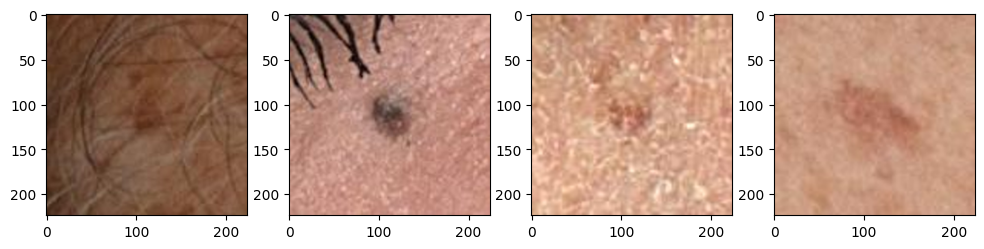

In [13]:
images, labels, image_ids = load_images_and_labels('train-image.hdf5', train_benign_ids, train_malignant_ids, num_images=4)
nrows, ncols = 4, 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i, image in enumerate(images):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)

plt.show()

## Defining the model

In this section we define our models for the detection.

This function provides a straightforward way to create an instance of an ImageDataGenerator.

In [14]:
def create_image_generator():
  return ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      rotation_range=30,
      brightness_range=[0.8, 1.2],
      width_shift_range=0.2,
      height_shift_range=0.2
  )

It is a helper function for image loading.

In [15]:
def load_and_preprocess_image(image_data):
    image = Image.open(io.BytesIO(image_data))
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    return np.array(image)

In these sections I define the datagenerator.

In [16]:
def next_data_generator(benign_ids, malignant_ids, image_generator):
  ids = benign_ids + malignant_ids
  id_cycle = itertools.cycle(ids)

  while True:
      with h5py.File('train-image.hdf5', 'r') as f:
          img_id = next(id_cycle)
          image = load_and_preprocess_image(f[img_id][()])
          label = 1 if img_id in malignant_ids else 0
          yield image / 255.0, label

          if label == 1:
              for _ in range(NUMBER_OF_AUGMENTATIONS):
                  yield image_generator.random_transform(image), label

Added a parameter called 'is_training' to determine whether augmentation should be applied or not.

In [17]:
def data_generator(benign_ids, malignant_ids, image_generator, batch_size=32):
  get_next = next_data_generator(benign_ids, malignant_ids, image_generator)

  while True:
      batch_data, batch_labels = zip(*(
          next(get_next) for _ in range(batch_size)
      ))

      yield np.array(batch_data), np.array(batch_labels)

This function defines the model.

In [18]:
def build_model(hp):
  base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
  x = Dense(hp.Int('dense_units', 128, 512, step=64), activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
  output = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=output)

  model.compile(
      optimizer=SGD(
          learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'),
          momentum=0.9
      ),
      loss='binary_crossentropy',
      metrics=['recall', 'precision']
  )

  return model

Here I define the Hyperparameter optimizer.

In [19]:
tuner = keras_tuner.Hyperband(
  build_model,
  objective='val_precision',
  max_epochs=10,
  factor=3,
  directory='output',
  project_name='DP42_with_hp'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


This section executes the hyperprameter optimization. Indeed, the valid_datagen is unnecessary, but for clarity it remaind as it is.

In [20]:
image_generator = create_image_generator()

train_generator = data_generator(train_benign_ids, train_malignant_ids, image_generator, BATCH_SIZE)
validation_generator = data_generator(valid_benign_ids, valid_malignant_ids, image_generator, BATCH_SIZE)

steps_per_epoch = (len(train_benign_ids) + len(train_malignant_ids) * (NUMBER_OF_AUGMENTATIONS + 1)) // BATCH_SIZE
validation_steps = (len(valid_benign_ids) + len(valid_malignant_ids) * (NUMBER_OF_AUGMENTATIONS + 1)) // BATCH_SIZE

tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=10,
             steps_per_epoch= steps_per_epoch,
             validation_steps=validation_steps)

Trial 4 Complete [00h 01m 03s]
val_precision: 0.23786407709121704

Best val_precision So Far: 1.0
Total elapsed time: 00h 04m 25s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
0.3               |0.4               |dropout
192               |128               |dense_units
0.0067873         |0.00013163        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.8186 - precision: 0.2376 - recall: 0.1632

KeyboardInterrupt: 

Here, I define the required callbacks.

In [21]:
callbacks = [
  EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max'),
  ReduceLROnPlateau(monitor='val_precision', factor=0.1, patience=3, min_lr=1e-6, mode='max'),
  ModelCheckpoint(filepath='best_model.keras', monitor='val_precision', save_best_only=True, mode='max')
]

Training the model.  
This might also be the subject of different modifications in the future.

In [22]:
best_model = tuner.get_best_models(num_models=1)[0]

hist = best_model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  epochs=50,
  verbose=2,
  callbacks=callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
78/78 - 42s - 539ms/step - loss: 0.9068 - precision: 0.5066 - recall: 0.4857 - val_loss: 0.7391 - val_precision: 1.0000 - val_recall: 0.2194 - learning_rate: 1.3163e-04
Epoch 2/50
78/78 - 17s - 218ms/step - loss: 0.9148 - precision: 0.4971 - recall: 0.4738 - val_loss: 0.7106 - val_precision: 1.0000 - val_recall: 0.2137 - learning_rate: 1.3163e-04
Epoch 3/50
78/78 - 17s - 215ms/step - loss: 0.9039 - precision: 0.5113 - recall: 0.4865 - val_loss: 0.7142 - val_precision: 1.0000 - val_recall: 0.2672 - learning_rate: 1.3163e-04
Epoch 4/50
78/78 - 15s - 197ms/step - loss: 0.8790 - precision: 0.5102 - recall: 0.4944 - val_loss: 0.7341 - val_precision: 1.0000 - val_recall: 0.2901 - learning_rate: 1.3163e-04
Epoch 5/50
78/78 - 16s - 206ms/step - loss: 0.8637 - precision: 0.5068 - recall: 0.5016 - val_loss: 0.6858 - val_precision: 1.0000 - val_recall: 0.4046 - learning_rate: 1.3163e-05
Epoch 6/50
78/78 - 16s - 205ms/step - loss: 0.8852 - precision: 0.4992 - recall: 0.4810 - val_loss: 

In this block of code

In [25]:
def unfreeze_model(model):
    for layer in model.layers:
          layer.trainable = True

    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['recall', 'precision'])

In this section I execute a second fitting process for better perfomance.

In [26]:
unfreeze_model(best_model)

hist = best_model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=10,
  verbose=2,
  batch_size=BATCH_SIZE,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  callbacks=callbacks
)

Epoch 1/10
78/78 - 80s - 1s/step - loss: 0.9342 - precision: 0.5059 - recall: 0.5135 - val_loss: 0.7572 - val_precision: 1.0000 - val_recall: 0.2715 - learning_rate: 1.0000e-04
Epoch 2/10
78/78 - 17s - 216ms/step - loss: 0.9214 - precision: 0.5106 - recall: 0.4960 - val_loss: 0.9282 - val_precision: 0.3299 - val_recall: 0.4167 - learning_rate: 1.0000e-04
Epoch 3/10
78/78 - 16s - 211ms/step - loss: 0.9151 - precision: 0.4960 - recall: 0.4937 - val_loss: 0.7957 - val_precision: 0.3744 - val_recall: 0.5064 - learning_rate: 1.0000e-04
Epoch 4/10
78/78 - 15s - 196ms/step - loss: 0.9197 - precision: 0.5040 - recall: 0.4984 - val_loss: 0.6938 - val_precision: 1.0000 - val_recall: 0.3333 - learning_rate: 1.0000e-04
Epoch 5/10
78/78 - 16s - 203ms/step - loss: 0.8994 - precision: 0.5047 - recall: 0.5103 - val_loss: 0.7966 - val_precision: 0.4159 - val_recall: 0.6026 - learning_rate: 1.0000e-05


Here we fill an aray with the predictions to simplify the code for the visualizations later.

In [27]:
benign_ids = benign_samples['isic_id'].tolist()

test_ids = benign_ids[6000:15000] + test_malignant_ids
predictions_train = np.zeros((len(test_ids), 1))

with h5py.File('train-image.hdf5', 'r') as f:
  for i, img_id in enumerate(test_ids):
      image_data = f[img_id][()]
      image = Image.open(io.BytesIO(image_data)).resize((224, 224))
      image_array = tf.keras.preprocessing.image.img_to_array(image)
      image_array = np.expand_dims(image_array, axis=0)

      prediction = best_model.predict(image_array, verbose=0)
      predictions_train[i] = prediction

predictions_train.shape

(9039, 1)

This function creates a confusion matrix for better visualization.

In [28]:
def create_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In this block, we evaluate the model on a larger test dataset to gather more insights.

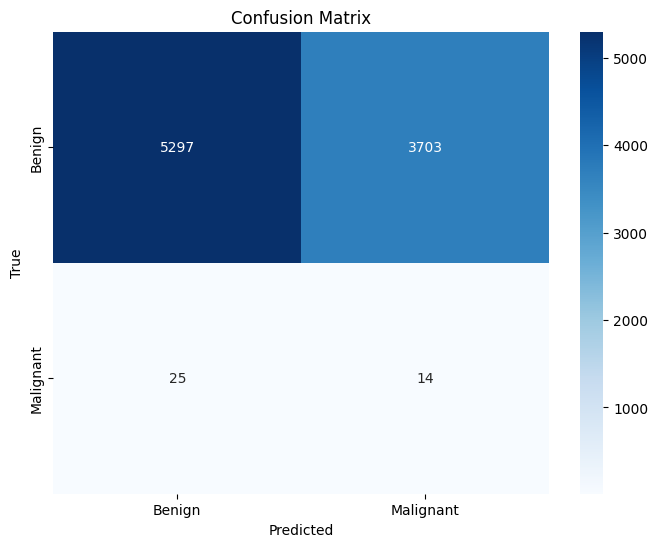

In [29]:
true_labels_train = [0 if img_id in benign_ids else 1 for img_id in test_ids]
predicted_labels_train = (predictions_train > 0.5).astype(int)
confusion_matrix_result = confusion_matrix(true_labels_train, predicted_labels_train)
create_confusion_matrix(confusion_matrix_result)

Partial area under the ROC curve (pAUC) above 80% true positive rate (TPR) for binary classification of malignant examples.

The receiver operating characteristic (ROC) curve illustrates the diagnostic ability of a given binary classifier system as its discrimination threshold is varied. However, there are regions in the ROC space where the values of TPR are unacceptable in clinical practice. Systems that aid in diagnosing cancers are required to be highly-sensitive, so this metric focuses on the area under the ROC curve AND above 80% TRP. Hence, scores range from [0.0, 0.2].

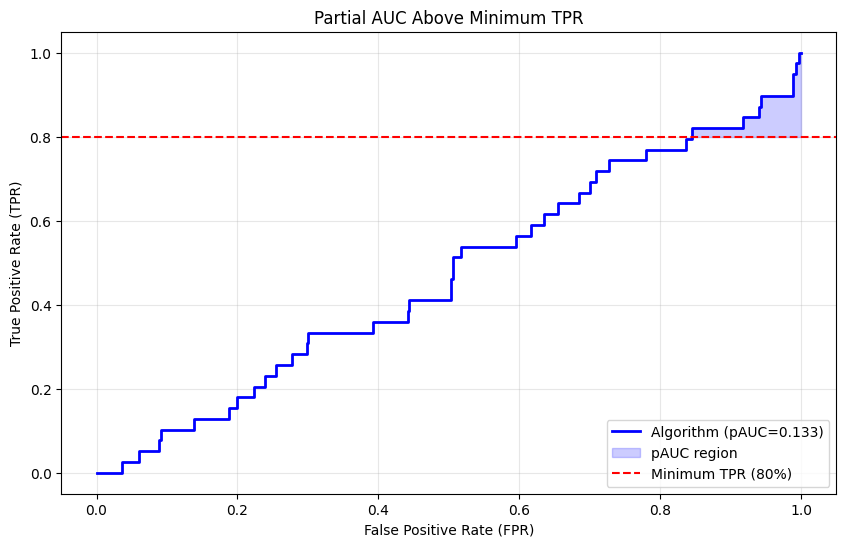

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def generate_pAUC_plot(algorithm_probs, true_labels, min_tpr=0.8):
  fpr_a, tpr_a, _ = roc_curve(true_labels, algorithm_probs)

  min_tpr_idx_a = np.where(tpr_a >= min_tpr)[0]

  fpr_a_high_tpr, tpr_a_high_tpr = fpr_a[min_tpr_idx_a], tpr_a[min_tpr_idx_a]

  if len(fpr_a_high_tpr) < 2:
      print("Warning: Insufficient data points to calculate pAUC. Returning 0.")
      pAUC_a = 0.0
  else:
      pAUC_a = auc(fpr_a_high_tpr, tpr_a_high_tpr)

  plt.figure(figsize=(10, 6))
  plt.plot(fpr_a, tpr_a, label=f'Algorithm (pAUC={pAUC_a:.3f})', color='blue', linewidth=2)

  if len(fpr_a_high_tpr) > 0 :
      plt.fill_between(fpr_a_high_tpr, tpr_a_high_tpr, min_tpr, color='blue', alpha=0.2, label='pAUC region')

  plt.axhline(y=min_tpr, color='red', linestyle='--', label=f'Minimum TPR ({min_tpr*100:.0f}%)')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Partial AUC Above Minimum TPR')
  plt.legend(loc='lower right')
  plt.grid(alpha=0.3)
  plt.show()

generate_pAUC_plot(predictions_train, true_labels_train)